# Is Monday Effect an Urban Myth?

**Authors**: Blythe King, Dinggyue Lie, Lucy (Yu) Xue\*, Sungbin Youk\
**Date**: May 30th, 2021\
**Description**: As a final project for PSTAT 234 in University of California, Santa Barbara, the authors examined the presence of Monday effect. \
The authors equally contributed to the project. The names of the authors are in an alphabetical order. The corresponding author is indicated with *.
----

**Table of Contents**
1. [Introduction](#introduction)\
    A. [Predicting the Stock Market](#predicting-the-stock-market)\
    B. [What is Monday Effect](#what-is-monday-effect)\
    C. [Our Objectives](#our-objectives)
2. [Tackling Objective 1](#tackling-objective-1)
3. [Tackling Objective 2](#tackling-objective-2)

## Introduction<a clas ="anchor" id = "introduction"></a>

### Predicting the Stock Market <a clas ="anchor" id = "predicting-the-stock-market"></a>

It will be great if you can predict the changes in the stock market. It will make you rich. Isn't that everyone's dream? Unfortunately, [efficient market hypothesis](https://www.investopedia.com/terms/e/efficientmarkethypothesis.asp) postulates that generating a stable parameter that reflects the share prices is impossible as the share prices reflect all information. 

It would be against the efficient market hypothesis if there is a predictable *pattern* in the stock market. In 1973, [Frank Cross](https://www.jstor.org/stable/pdf/4529641.pdf?refreqid=excelsior%3Adeff8e6e9e2c4c0b275b4b03a21b9c13) documented a non-random movement in stock prices. Here are the main findings from examining the Standard & Poor's Composite Stock Index from 1953 to 1970:
- The index have risen on Friday more often than on any other days of the week, and have risen least often on Monday. 
- When the Friday index declined, the Monday index was more likely to also see a decline. When the Friday index advanced, the Monday index was likely to remain static (neither advancing nor declining). 

### What is Monday Effect? <a clas ="anchor" id = "what-is-monday-effect"></a>

Over the years, Frank Cross's findings were coined into what is now known as the **Monday Effect**. There are two different definitions of the monday effect (each corresponding to the two findings that are mentioned above). 

- Monday effect states that the returns on Monday are less than the other days of the week, and are often negative on average ([Pettengill, 2003](https://www.jstor.org/stable/pdf/23292837.pdf?refreqid=excelsior%3A6da162ff7d91746d901fc154171e6015)).
- Monday effect states that the returns on the stock market on Monday, especially the first few hours, will follow the pattern of the previous Friday, espeically the last few hours ([Investopedia](https://www.investopedia.com/terms/m/mondayeffect.asp)). 

You may wonder what may be the reason behind this abnormality in the stock prices. As the existence of Monday effect is controversial (thus, the reason for our project), there isn't a clear answer. Some state that the stock returns are low on Monday because companies may hold on to bad news until the last day of stock trading (Friday), which in turn makes the next stock trading day (Monday) to take the hit. 

### Our Objectives <a clas ="anchor" id = "our-objectives"></a>

The objective of our project is in three-folds:
1) The first objective is to examine the first definitoin of Monday effect (i.e. the stock returns of Monday is less than the other days of the week). We will benchmark [Arman and Lestari's study](https://www.atlantis-press.com/proceedings/icame-18/125917114). They examined Monday effect in the Indonesian Stock Exchange. We will examine if Monday effect is also present in the U.S. stock market.\
2) The second objective of this study is to examine the second definition of Monday effect. We will examine if Monday's returns are correlated to that of Friday.\
3) We will take a step further and apply time series analysis to see "abnormailities" is stock returns.

----
## Tackling Objective 1 <a clas ="anchor" id = "tackling-objective-1"></a>

In our analysis, the stock return data are obtained from yfinance package in python. We will create two sets of data. The first data will include the stock returns of S&P 500 from 2014 to 2017. This data set has the identical timeframe to that of Arman and Lestari's study. The second dataset includes the latest S&P 500 constituents. 

### A Short Summary of Arman and Lestari's Study

Arman and Lestari examined the Monday effect by examining the banking sectors on the Indonesian stock market from 2014 to 2017. A one-sample t-test was conducted for each of the weekdays. The results indicated that the average stock return on Monday is -0.0006, which was not statistically significant. 

### Importing Libraries and Packages

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import requests
import datetime
from datetime import date
import calendar
import io
from scipy import stats

### Importing the list of ticker for S&P 500 between 2014 to 2017

The first step is to retrieve the companies that constituted S&P 500 in the past. 

In [ ]:
# Downloading the csv file from a Github page which has a list of companies and when they were added or removed from S&P 500
url = "https://raw.githubusercontent.com/leosmigel/analyzingalpha/master/sp500-historical-components-and-changes/sp500_history.csv"
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe
df = pd.read_csv(io.StringIO(download.decode('utf-8')))

#Turning the date column into a datetime object
df["date"] = pd.to_datetime(df["date"])

# Printing out the first 5 rows of the dataframe
df.head()

In [ ]:
# Function to retrieve the tickers in S&P 500 for a given timeframe
def past_SP_ticker(end_date):
    ticker_list = []
    global df
    for index,row in df.iterrows():
        if row['date'] > end_date:
            break
        else:
            if row['variable'] == "added_ticker":
                ticker_list.append(row['value'])
            elif row['value'] in ticker_list:
                ticker_list.remove(row['value'])
    return ticker_list

In [ ]:
# Using the past_SP_ticker() function to retrieve the tickers of S&P 500 for 2017. 
end_date = '20171231'
date_time_obj = datetime.datetime.strptime(end_date,'%Y%m%d')
SP_ticker_2017 = past_SP_ticker(date_time_obj)

### Creating a dataframe of stock returns for the identified S&P 500 constituents of 2017
The next step is to obtain the daily stock returns of the selected companies. This requires several steps: obtain the stock data of the S&P 500 constituents of 2017, delete the missing values, calculate the log retruns, create a multilevel index (i.e., hierarchical index) with the days of the week

#### Obtaining the stock data of S&P 500 constituents of 2017

In [ ]:
# Using the ticker to obtain stock prices from yfinance
rawdata = yf.download(SP_ticker_2017, start="2013-12-31", end="2017-12-31")
rawdata.columns = rawdata.columns.set_names(['Value', 'Symbol'])
rawdata.head()

#### Deleting the missing values

In [ ]:
# Inspecting the missing values in terms of rows
rawdata['Close'].isna().sum(axis=0).describe()

In [ ]:
# Making an list of tuples for tickers that has more than 3 missing values
high_missing_ticker = rawdata['Close'].isna().sum(axis=0) > 3
high_missing_ticker_list = high_missing_ticker[high_missing_ticker].index.tolist()
high_missing_ticker_tuples = list()
for i in ['Adj Close', 'Open', 'Close', 'High' ,'Low', 'Volume']:
    high_missing_ticker_tuples += list(zip([i]*len(high_missing_ticker_list),high_missing_ticker_list))

In [ ]:
# Excluding columns (i.e., tickers) that has more than 3 missing values 
rawdata = rawdata.drop(high_missing_ticker_tuples, axis = 1)

In [ ]:
# Finding out the dates that all tickers (columns) have missing values
missingdate =rawdata.isna().sum(axis=1) > 0
missingdate[missingdate].index

In [ ]:
# delete the first row if it has missing values
if rawdata.iloc[0].isna().sum().any():
    rawdata = rawdata.iloc[1:]

In [ ]:
# other rows with missing values are replaced with the values from the previous date
rawdata = rawdata.fillna(method= 'ffill')

In [ ]:
# Double check to see if all the missing values were either removed or replaced
(rawdata.isna().sum(axis=None)>0).any()

#### Calculating the log returns for closing price

In [ ]:
# Getting the log returns from stock prices
logret = np.log(rawdata['Close']).diff()
logret.columns = pd.MultiIndex.from_product([['logreturn'], logret.columns])
# Joining logret and rawdata 
rawdata = rawdata.join(logret)
# row with the index of 2013-12-31 will be deleted as it is out of the scope of our data (2014~2017)
rawdata = rawdata.drop(pd.Timestamp('2013-12-31'))

In [ ]:
print("After preprocessing the data, we have idenified the log returns of {} companies, which were included in S&P500 in 2017. To recap, we are examining the stock returns from 2014 to 2017. Therefore, we will be examining the stock returns of {} days".format(len(logret.columns), len(logret)))

#### Creating a new columns for the industry information

In [ ]:
# Obtaining the information about the tickers that are included in SP_ticker_2017
industry_dic = dict()
for item in SP_ticker_2017:
    try:
        industry_dic[item] = yf.Ticker(item).info['industry']
    except:
        industry_dic[item] = None

In [ ]:
# Adding the industry to a level of the column
rawdata.columns = pd.MultiIndex.from_tuples([(value, industry_dic[ticker], ticker) for value, ticker in rawdata.columns])
rawdata.head()

#### Creating a new columns for days of the week

In [ ]:
# The day of the week is added as a new index (creating a hierarchical index)
rawdata['days'] = [calendar.day_name[day.weekday()] for day in rawdata.index]

#### Exporting dataframe as csv

In [ ]:
rawdata.to_csv('SP500_2014_2017_multilevel.csv')

#### Staking the Closing and Log returns into one dataframe

For convenience in running some of the statistical analyses, the multilevel data of stock values are stacked into a dataframe. 

In [ ]:
# To easily stack the data, it is easier to delete the days and industry information.
rawdata = rawdata.drop('days', axis =1)
rawdata.columns = rawdata.columns.droplevel(1)

In [ ]:
# The data is stacked 
stacked_rawdata = rawdata.stack()
stacked_rawdata.reset_index(inplace=True)
stacked_rawdata = stacked_rawdata.rename(columns = {'level_1':'Ticker'})

# Days are added as a new column
stacked_rawdata['days'] = [calendar.day_name[day.weekday()] for day in stacked_rawdata['Date']]

# Industry information is added as a new column
stacked_rawdata['Industry'] = [industry_dic[ticker] for ticker in stacked_rawdata['Ticker']]
stacked_rawdata.head()

#### Exporting dataframe as csv

In [ ]:
stacked_rawdata.to_csv('SP500_2014_2017_stacked.csv')

Let's repeat what we just did to create the stock returns data for the latest S&P 500 constituents

### Creating a dataframe of stock returns for the latest S&P 500 constituents
The list of constituents for the latest S&P500 are available in `list of sp500.xlsx` file. 

In [ ]:
SP500list = pd.read_excel('list of sp500.xlsx', engine='openpyxl')
SP_ticker_2020 = SP500list['Symbol'].tolist()

### Obtaining the stock data of latest S&P 500 constituents

In [ ]:
# Using the ticker to obtain stock prices from yfinance
rawdata = yf.download(SP_ticker_2020, start="2017-12-30", end="2021-05-28")
rawdata.columns = rawdata.columns.set_names(['Value', 'Symbol'])
rawdata.head()

#### Deleting the missing values

In [ ]:
# Inspecting the missing values in terms of rows
rawdata['Close'].isna().sum(axis=0).describe()

In [ ]:
# Making an list of tuples for tickers that has more than 3 missing values
high_missing_ticker = rawdata['Close'].isna().sum(axis=0) > 3
high_missing_ticker_list = high_missing_ticker[high_missing_ticker].index.tolist()
high_missing_ticker_tuples = list()
for i in ['Adj Close', 'Open', 'Close', 'High' ,'Low', 'Volume']:
    high_missing_ticker_tuples += list(zip([i]*len(high_missing_ticker_list),high_missing_ticker_list))

In [ ]:
# Excluding columns (i.e., tickers) that has more than 3 missing values 
rawdata = rawdata.drop(high_missing_ticker_tuples, axis = 1)

In [ ]:
# Finding out the dates that all tickers (columns) have missing values
missingdate =rawdata.isna().sum(axis=1) > 0
missingdate[missingdate].index

In [ ]:
# delete the first row if it has missing values
if rawdata.iloc[0].isna().sum().any():
    rawdata = rawdata.iloc[1:]

In [ ]:
# other rows with missing values are replaced with the values from the previous date
rawdata = rawdata.fillna(method= 'ffill')

In [ ]:
# Double check to see if all the missing values were either removed or replaced
(rawdata.isna().sum(axis=None)>0).any()

#### Calculating the log returns for closing price

In [ ]:
# Getting the log returns from stock prices
logret = np.log(rawdata['Close']).diff()
logret.columns = pd.MultiIndex.from_product([['logreturn'], logret.columns])
# Joining logret and rawdata 
rawdata = rawdata.join(logret)

In [ ]:
print("After preprocessing the data, we have idenified the log returns of {} companies, which were included in S&P500 in 2021. To recap, we are examining the stock returns from 2018 to May 2021. Therefore, we will be examining the stock returns of {} days".format(len(logret.columns), len(logret)))

#### Creating a new columns for the industry information

In [ ]:
# Obtaining the information about the tickers that are included in SP_ticker_2017
industry_dic = dict()
for item in SP_ticker_2020:
    try:
        industry_dic[item] = yf.Ticker(item).info['industry']
    except:
        industry_dic[item] = None

In [ ]:
# Adding the industry to a level of the column
rawdata.columns = pd.MultiIndex.from_tuples([(value, industry_dic[ticker], ticker) for value, ticker in rawdata.columns])
rawdata.head()

#### Creating a new columns for days of the week

In [ ]:
# The day of the week is added as a new index (creating a hierarchical index)
rawdata['days'] = [calendar.day_name[day.weekday()] for day in rawdata.index]

#### Exporting dataframe as csv

In [ ]:
rawdata.to_csv('SP500_2018_2021_multilevel.csv') 

#### Staking the Closing and Log returns into one dataframe

For convenience in running some of the statistical analyses, the multilevel data of stock values are stacked into a dataframe. 

In [ ]:
# To easily stack the data, it is easier to delete the days and industry information.
rawdata = rawdata.drop('days', axis =1)
rawdata.columns = rawdata.columns.droplevel(1)

In [ ]:
# The data is stacked 
stacked_rawdata = rawdata.stack()
stacked_rawdata.reset_index(inplace=True)
stacked_rawdata = stacked_rawdata.rename(columns = {'level_1':'Ticker'})

# Days are added as a new column
stacked_rawdata['days'] = [calendar.day_name[day.weekday()] for day in stacked_rawdata['Date']]

# Industry information is added as a new column
stacked_rawdata['Industry'] = [industry_dic[ticker] for ticker in stacked_rawdata['Ticker']]
stacked_rawdata.head()

# Before we forget, let's add the days and industry column back to our rawdata. We will comeback to this later
rawdata.columns = pd.MultiIndex.from_tuples([(value, industry_dic[ticker], ticker) for value, ticker in rawdata.columns])
rawdata['days'] = [calendar.day_name[day.weekday()] for day in rawdata.index]


#### Exporting dataframe as csv

In [ ]:
stacked_rawdata.to_csv('SP500_2018_2021_stacked.csv')

### Analyzing the Monday Effect
The next step is to analyze the Monday effect. First, as done in Arman and Lestari's research, one-sample t-test is conducted for each day of the week. The test value is 0. Therefore, a significant result indicates that it is highly unlikely to have obtained the average log stock returns on a specific day of the week given that the null hypothesis is true (i.e. the average log stock return is 0).

##### Descriptive Statistics

In [ ]:
# Let's examine how many columns we have
print('There are {} columns in our dataset'.format(len(rawdata.columns)))
# The days of the week is one of the columns
print('Is days one of the columns?','days' in rawdata.columns)

In [ ]:
# Before we move on, let's make a multilevel index for the rows.
rawdata.set_index('days', append=True, inplace=True)

In [ ]:
# Frequency count for each day
rawdata['logreturn'].groupby(level=1).count().mean(axis=1)

In [ ]:
# Before we get into conducting one sample t-test, 
# let's look at the mean of log stock returns for each day of the week
rawdata['logreturn'].groupby(level=1).mean().mean(axis=1).sort_values()

In [ ]:
# Let's look at the standard deviation of log stock returns for each day of the week
rawdata['logreturn'].groupby(level=1).std().std(axis=1).sort_values()

Although less tha Thursday, Monday has a negative log stock returns and a largest variance. Let's see if this value is statistically significant. 

##### Inferential Statistics

###### t-test

In [ ]:
def one_sample_t(day):
    a = rawdata.xs(day, level='days').logreturn.values.flatten()
    a = a[~numpy.isnan(a)]
    return stats.ttest_1samp(a,0)

In [ ]:
# one-sample t-test for Monday
one_sample_t('Monday')

In [ ]:
# one-sample t-test for Tuesday
one_sample_t('Tuesday')

In [ ]:
# one-sample t-test for Wednesday
one_sample_t('Wednesday')

In [ ]:
# one-sample t-test for Thursday
one_sample_t('Thursday')

In [ ]:
# one-sample t-test for Friday
one_sample_t('Friday')

----------

## Tackling Objective 2  <a clas ="anchor" id = "tackling-objective-2"></a>

In this section, we will examine Monday effect in term of its second defintion. We will use the same data that were used in the previous section. 

Disclaimer: did you know that you can run R codes in a python based jupyter notebook? Well, the environment that this notebook is built on allows for that with the use of [rpy2](https://pypi.org/project/rpy2/) package. We simply use `%%R` in the cell that we want to run R codes. `%%R` is called R magic (and yes, magic indeed). 

### Setting up R and Importing R libraries

In [1]:
#Let's import rpy2
import rpy2
#The following code enables you to use R magic
%load_ext rpy2.ipython

C:\Users\SungbinYouk-PC\miniconda3\envs\stockproject\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
%%R
#Let's load the R packages that we will use, we will use `pacman` library to help us load all other libraries 
install.packages("pacman")
library(pacman)
p_load(dplyr, plyr, readr, tidyr, reshape, ggplot2, sjPlot)

R[write to console]: Installing package into 'C:/Users/SungbinYouk-PC/Documents/R/win-library/4.0'
(as 'lib' is unspecified)



--- Please select a CRAN mirror for use in this session ---


R[write to console]: trying URL 'https://repo.miserver.it.umich.edu/cran/bin/windows/contrib/4.0/pacman_0.5.1.zip'

R[write to console]: Content type 'application/octet-stream'
R[write to console]:  length 389623 bytes (380 KB)

R[write to console]: downloaded 380 KB




package 'pacman' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\SungbinYouk-PC\AppData\Local\Temp\RtmpqUHg86\downloaded_packages


### Importing the data for S&P 500 constituents in 2017

In [ ]:
%%R
#Let's read in the .csv file of the stock returns for S&P 500 constituents in 2017
SP500_2014_2017_stacked <- read_csv("SP500_2014_2017_stacked.csv")

#We will sort the dataset by company (i.e. tickers)
all_data <- SP500_2014_2017_stacked[order(SP500_2014_2017_stacked$Ticker),]

#The numeric date will be used as an index to pair log returns of two consecutive days
Date_num = as.numeric(all_data$Date)
all_data["Date_num"]=Date_num 

#Before we move on, let's clean the data by removing the date variable
all_data_no_date = subset(all_data, select = -Date)

# Let's generate a list of unique companies (i.e. unique tickers)
Ticker_list = unique(all_data_no_date$Ticker)

### Seperating the dataset based on the days of the week

In [ ]:
%%R
#We wil now make pairs of og-return for two consecutive days
Monday = Tuesday = Wednesday = Thursday = Friday = Next_Monday = {}

for (ticker in Ticker_list){
  Company_temp = {}
  Monday_temp = {}
  # Let's take one company at a time
  Company_temp = filter(all_data_no_date,Ticker == ticker)
  # We will use Monday as the benchmark for finding pairs
  Monday_temp = filter(Company_temp,days == "Monday")
  Monday = rbind(Monday, Monday_temp)
  
  for (date in Monday_temp$Date_num){
    #Friday is 4 days after Monday
    Friday_temp =  subset(Company_temp, Date_num == (date+4))
    #If there is no data for the following Friday, set as NA
    if(dim(Friday_temp)[1] == 0){Friday_temp = NA}
    Friday = rbind(Friday,Friday_temp)
    #We will repeat this for all other days of the week
    Thursday_temp = subset(Company_temp, Date_num == (date+3))
    if(dim(Thursday_temp)[1] == 0){Thursday_temp = NA}
    Thursday = rbind(Thursday,Thursday_temp)
    
    Wednesday_temp = subset(Company_temp, Date_num == (date+2))
    if(dim(Wednesday_temp)[1] == 0){Wednesday_temp = NA}
    Wednesday = rbind(Wednesday,Wednesday_temp)
    
    Tuesday_temp = subset(Company_temp, Date_num == (date+1))
    if(dim(Tuesday_temp)[1] == 0){Tuesday_temp = NA}
    Tuesday = rbind(Tuesday,Tuesday_temp)
    
    Next_Monday_temp = subset(Company_temp, Date_num == (date+7))
    if(dim(Next_Monday_temp)[1] == 0){Next_Monday_temp = NA}
    Next_Monday = rbind(Next_Monday,Next_Monday_temp)
  }
}

#Let's save the data sets for each days of the week to .csv files
write.csv(Monday,"Monday.csv", row.names = FALSE)
write.csv(Tuesday,"Tuesday.csv", row.names = FALSE)
write.csv(Wednesday,"Wednesday.csv", row.names = FALSE)
write.csv(Thursday,"Thursday.csv", row.names = FALSE)
write.csv(Friday,"Friday.csv", row.names = FALSE)
write.csv(Next_Monday,"Next_Monday.csv", row.names = FALSE)

### Reading in the datasets for each days of the week

In [3]:
%%R
#
Monday = read_csv("Monday.csv")
Tuesday = read_csv("Tuesday.csv")
Wednesday = read_csv("Wednesday.csv")
Thursday = read_csv("Thursday.csv")
Friday = read_csv("Friday.csv")
Next_Monday = read_csv("Next_Monday.csv")

Monday['Index']= 1:nrow(Monday)
Tuesday['Index']= 1:nrow(Tuesday)
Wednesday['Index']= 1:nrow(Wednesday)
Thursday['Index']= 1:nrow(Thursday)
Friday['Index']= 1:nrow(Friday)
Next_Monday['Index']= 1:nrow(Next_Monday)


-- Column specification -------------------------------------------------------------------------------------------------------------------------------------
cols(
  X1 = col_double(),
  Ticker = col_character(),
  `Adj Close` = col_double(),
  Close = col_double(),
  High = col_double(),
  Low = col_double(),
  Open = col_double(),
  Volume = col_double(),
  logreturn = col_double(),
  days = col_character(),
  Industry = col_character(),
  Date_num = col_double()
)


-- Column specification -------------------------------------------------------------------------------------------------------------------------------------
cols(
  X1 = col_double(),
  Ticker = col_character(),
  `Adj Close` = col_double(),
  Close = col_double(),
  High = col_double(),
  Low = col_double(),
  Open = col_double(),
  Volume = col_double(),
  logreturn = col_double(),
  days = col_character(),
  Industry = col_character(),
  Date_num = col_double()
)


-- Column specification ---------------------------

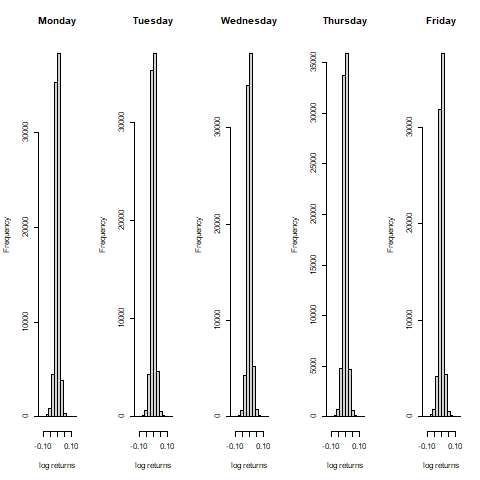

In [4]:
%%R
#histogram of log-return on each day
par(mfrow=c(1,5))
hist(Monday$logreturn,xlim = c(-0.12,0.12),breaks = 40, main = "Monday", xlab = 'log returns')
hist(Tuesday$logreturn,xlim = c(-0.12,0.12),breaks = 40, main = "Tuesday", xlab = 'log returns')
hist(Wednesday$logreturn,xlim = c(-0.12,0.12),breaks = 40, main = "Wednesday", xlab = 'log returns')
hist(Thursday$logreturn,xlim = c(-0.12,0.12),breaks = 40, main = "Thursday", xlab = 'log returns')
hist(Friday$logreturn,xlim = c(-0.12,0.12),breaks = 40, main = "Friday", xlab = 'log returns')

The histograms illustrate the frequency distribution of the log returns for each days of the week. Does this sound familiar? Yes, this is related to the first definition of Monday returns. By looking at the distribution, the log returns are close to zero for all days of the week. In fact, the number of days in which the log returns are slighly above zero is higher than thos slighly less than zero for all days of the week. Therefore, Monday effect in term of its first definition seems less promising. However, this section is related to the second definition of Monday effect. So, let's dive into examining the relationship between two consecutive days of the week. We will examine the linear regression on the pairs of consecutive days of the week.  

### Examining the relationship between the pairs of consecutive days of the week

In [7]:
%%R
# Let's look at the relationship between the log returns for pairs of consecutive days. A linear model is fit to the data.
fit_F_M = lm(Friday$logreturn~Next_Monday$logreturn)
fit_M_Tu = lm(Monday$logreturn~Tuesday$logreturn)
fit_Tu_W = lm(Tuesday$logreturn~Wednesday$logreturn)
fit_W_Th = lm(Wednesday$logreturn~Thursday$logreturn)
fit_Th_F = lm(Thursday$logreturn~Friday$logreturn)
tab_model(fit_F_M, fit_M_Tu, fit_Tu_W, fit_W_Th,fit_Th_F)

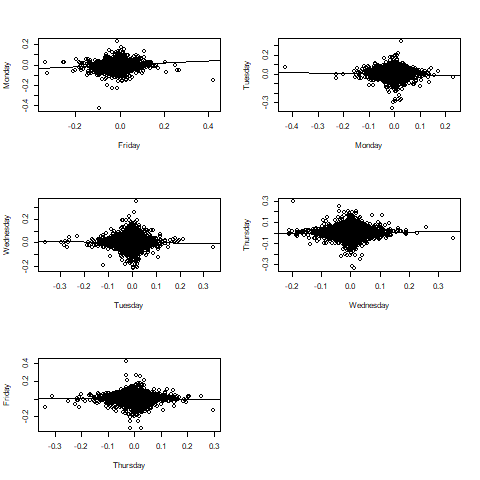

In [62]:
%%R
# Let's visualize our data. We will draw a scatter plot and the linear regression. 
layout(matrix(c(1,2,3,4,5,6), nrow = 3, ncol = 2, byrow = TRUE))
plot(Friday$logreturn,Next_Monday$logreturn,
    xlab = "Friday", ylab = "Monday")
abline(fit_F_M)
plot(Monday$logreturn,Tuesday$logreturn,
    xlab = "Monday", ylab = "Tuesday")
abline(fit_M_Tu)
plot(Tuesday$logreturn,Wednesday$logreturn,
    xlab = "Tuesday", ylab = "Wednesday")
abline(fit_Tu_W)
plot(Wednesday$logreturn,Thursday$logreturn,
    xlab = "Wednesday", ylab = "Thursday")
abline(fit_W_Th)
plot(Thursday$logreturn,Friday$logreturn,
    xlab = "Thursday", ylab = "Friday")
abline(fit_Th_F)
mtext("Linear relationship between two consecutive days", outer = TRUE, cex = 1.5)

There is a statistically significant relationship between all pairs of consecutive log returns. With this large of a sample size, a small relationship between the two values will be significant. Therefore, it is not encouraged to take the significance at the face value. We need to also consider the magnitude of the significance. The $R^2$ value indicates that around 0.8% of the variance in Monday returns are explained with the Friday returns. The $R^2$ for these two consecutive days are larger than all other pairs. 

In [65]:
%%R
# We will record the R-squared value and beta coefficents of this linear regression. This will be used later on to compare it to other days of the week.
fit_F_M_R2 = summary(fit_F_M)$r.squared
fit_M_Tu_R2 = summary(fit_M_Tu)$r.squared
fit_Tu_W_R2 = summary(fit_Tu_W)$r.squared
fit_W_Th_R2 = summary(fit_W_Th)$r.squared
fit_Th_F_R2 = summary(fit_Th_F)$r.squared
fit_F_M_Beta = fit_F_M$coef[2]
fit_M_Tu_Beta = fit_M_Tu$coef[2]
fit_Tu_W_Beta = fit_Tu_W$coef[2]
fit_W_Th_Beta = fit_W_Th$coef[2]
fit_Th_F_Beta = fit_Th_F$coef[2]
# Let's create a series that has R-squared values of linear models using all industries on each pair of days
r_before = c(fit_F_M_R2,fit_M_Tu_R2,fit_Tu_W_R2,fit_W_Th_R2,fit_Th_F_R2)
beta_before = c(fit_F_M_Beta, fit_M_Tu_Beta,fit_Tu_W_Beta, fit_W_Th_Beta, fit_Th_F_Beta)

### Examining the relationship between the pairs of consecutive days of the week for different industries

We just looked at the linear relationship between the pairs of consecutive days of the week across all S&P 500 constituents. However, it is possible for Monday effect to vary based on industries. In this sections, we will take a step further in examining Monday effect (don't forget that we are focusing on the second definition here) by analyzing how many industries show a significant relationship between consecutive days of the week.  

In [35]:
%%R
# To make things easier, we will create a function that will run linear models for each groups. In our case, the groups are the industries.
lm_by_group <- function(z) {
   model.fit <- data.frame(coef(summary(lm(y~x,data=z))))
   # The first row is the intercept and the second row is the slope
   model.fit$predictor <- rownames(model.fit)
   model.fit
}

# Let's create a linear model between Friday and the following Monday for each industry
lm_by_industry_M_F <- data.frame(group=Next_Monday$Industry,y=Next_Monday$logreturn,x=Friday$logreturn)
lm_by_industry_M_F = lm_by_industry_M_F %>% drop_na()
models_M_F <- ddply(lm_by_industry_M_F,"group",lm_by_group)


# Let's filter out the industries that do not have significant linear relationship
models_M_F_sig = filter(models_M_F, Pr...t.. <0.05)
industry_M_F_sig = unique(models_M_F_sig$group)

# Let's calculate the proportion of industries that showed a significant linear relatioship between Monday and Friday's log returns
M_F = sum(models_M_F$Pr...t..<0.05)/nrow(models_M_F)

# We will repeat what we did above for rest of the pairs of consecutive days
lm_by_industry_F_Th <- data.frame(group=Friday$Industry,y=Friday$logreturn,x=Thursday$logreturn)
lm_by_industry_F_Th = lm_by_industry_F_Th %>% drop_na()
models_F_Th <- ddply(lm_by_industry_F_Th,"group",lm_by_group)
F_Th = sum(models_F_Th$Pr...t..<0.05)/nrow(models_F_Th)
models_F_Th_sig = filter(models_F_Th, Pr...t.. <0.05)
industry_F_Th_sig = unique(models_F_Th_sig$group)


lm_by_industry_Th_W <- data.frame(group=Thursday$Industry,y=Thursday$logreturn,x=Wednesday$logreturn)
lm_by_industry_Th_W = lm_by_industry_Th_W %>% drop_na()
models_Th_W <- ddply(lm_by_industry_Th_W,"group",lm_by_group)
Th_W = sum(models_Th_W$Pr...t..<0.05)/nrow(models_Th_W)
models_Th_W_sig = filter(models_Th_W, Pr...t.. <0.05)
industry_Th_W_sig = unique(models_Th_W_sig$group)


lm_by_industry_W_Tu <- data.frame(group=Wednesday$Industry,y=Wednesday$logreturn,x=Tuesday$logreturn)
lm_by_industry_W_Tu = lm_by_industry_W_Tu %>% drop_na()
models_W_Tu <- ddply(lm_by_industry_W_Tu,"group",lm_by_group)
W_Tu = sum(models_W_Tu$Pr...t..<0.05)/nrow(models_W_Tu)
models_W_Tu_sig = filter(models_W_Tu, Pr...t.. <0.05)
industry_W_Tu_sig = unique(models_W_Tu_sig$group)


lm_by_industry_Tu_M <- data.frame(group=Tuesday$Industry,y=Tuesday$logreturn,x=Monday$logreturn)
lm_by_industry_Tu_M = lm_by_industry_Tu_M %>% drop_na()
models_Tu_M <- ddply(lm_by_industry_Tu_M,"group",lm_by_group)
Tu_M = sum(models_Tu_M$Pr...t..<0.05)/nrow(models_Tu_M)
models_Tu_M_sig = filter(models_Tu_M, Pr...t.. <0.05)
industry_Tu_M_sig = unique(models_Tu_M_sig$group)

#Let's compare the proportion of industries that showed signicant linear relationship between the consecutive day pairs
sig_est_perc = data.frame(M_F,F_Th,Th_W,W_Tu,Tu_M)
colnames(sig_est_perc) <- c("Monday & Friday","Friday & Thursday", "Thursday & Wednesday", "Wednesday & Tuesday", "Tuesday & Monday")
print(round(sig_est_perc,3), row.names = "Proportion of industries with significant relationships")

                                                        Monday & Friday
Proportion of industries with significant relationships           0.375
                                                        Friday & Thursday
Proportion of industries with significant relationships             0.203
                                                        Thursday & Wednesday
Proportion of industries with significant relationships                0.181
                                                        Wednesday & Tuesday
Proportion of industries with significant relationships               0.319
                                                        Tuesday & Monday
Proportion of industries with significant relationships            0.267


Compared to other pairs of consecutive days, Monday and Friday pair had the largest proportion (37.5%) of industries that had signiciant linear relationship between the log returns. This is twice as large as the proportion of industries for Thursday and Wednesday pair (18.1%). We just looked at the proprotion of the signiciant industries. To closely scrutinize Monday effect, we will investigate the $R^2$ and $\beta$ coefficients. This will provide how much of the variance of the log returns for a given day is explained with that of the previous day and also the strength as well as the direction of the effect.

In [60]:
%%R
# Let's select the subset of the data which includes the industries that had signicant relatinoship bewteen the Monday and Friday log returns 
Monday_Friday_M = subset(Next_Monday,Industry %in% industry_M_F_sig)
Monday_Friday_F = subset(Friday,Index %in% Monday_Friday_M$Index)

# Let's run the linear model again
fit_F_M_sig = lm(Monday_Friday_F$logreturn~Monday_Friday_M$logreturn)

# We will repeat these two steps for the rest of the pairs
Monday_Tuesday_M = subset(Monday,Industry %in% industry_Tu_M_sig)
Monday_Tuesday_Tu = subset(Tuesday,Index %in% Monday_Tuesday_M$Index)
fit_M_Tu_sig = lm(Monday_Tuesday_M$logreturn~Monday_Tuesday_Tu$logreturn)


Tuesday_Wednesday_Tu = subset(Tuesday,Industry %in% industry_W_Tu_sig)
Tuesday_Wednesday_W = subset(Wednesday,Index %in% Tuesday_Wednesday_Tu$Index)
fit_Tu_W_sig = lm(Tuesday_Wednesday_Tu$logreturn~Tuesday_Wednesday_W$logreturn)

Wednesday_Thursday_W = subset(Wednesday,Industry %in% industry_Th_W_sig)
Wednesday_Thursday_Th = subset(Thursday,Index %in% Wednesday_Thursday_W$Index)
fit_W_Th_sig = lm(Wednesday_Thursday_W$logreturn~Wednesday_Thursday_Th$logreturn)

Thursday_Friday_Th = subset(Thursday,Industry %in% industry_F_Th_sig)
Thursday_Friday_F = subset(Friday,Index %in% Thursday_Friday_Th$Index)
fit_Th_F_sig = lm(Thursday_Friday_Th$logreturn~Thursday_Friday_F$logreturn)

# Let's look at the relationship between the log returns for pairs of consecutive days for these industries
tab_model(fit_F_M_sig, fit_M_Tu_sig, fit_Tu_W_sig, fit_W_Th_sig,fit_Th_F_sig)


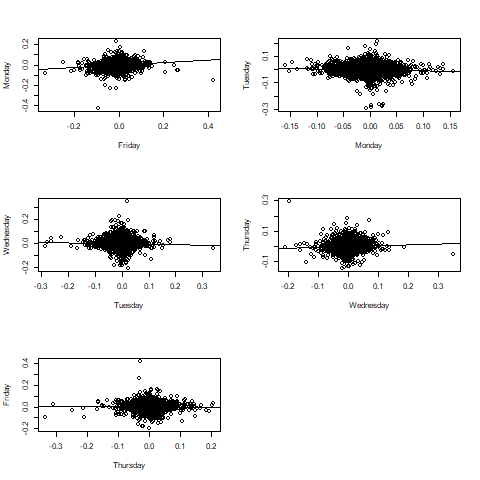

In [64]:
%%R
# Let's visualize our data. We will draw a scatter plot and the linear regression. 
layout(matrix(c(1,2,3,4,5,6), nrow = 3, ncol = 2, byrow = TRUE))
plot(Monday_Friday_F$logreturn,Monday_Friday_M$logreturn,
    xlab = "Friday", ylab = "Monday")
abline(fit_F_M_sig)
plot(Monday_Tuesday_M$logreturn,Monday_Tuesday_Tu$logreturn,
    xlab = "Monday", ylab = "Tuesday")
abline(fit_M_Tu_sig)
plot(Tuesday_Wednesday_Tu$logreturn,Tuesday_Wednesday_W$logreturn,
    xlab = "Tuesday", ylab = "Wednesday")
abline(fit_Tu_W_sig)
plot(Wednesday_Thursday_W$logreturn,Wednesday_Thursday_Th$logreturn,
    xlab = "Wednesday", ylab = "Thursday")
abline(fit_W_Th_sig)
plot(Thursday_Friday_Th$logreturn,Thursday_Friday_F$logreturn,
    xlab = "Thursday", ylab = "Friday")
abline(fit_Th_F_sig)

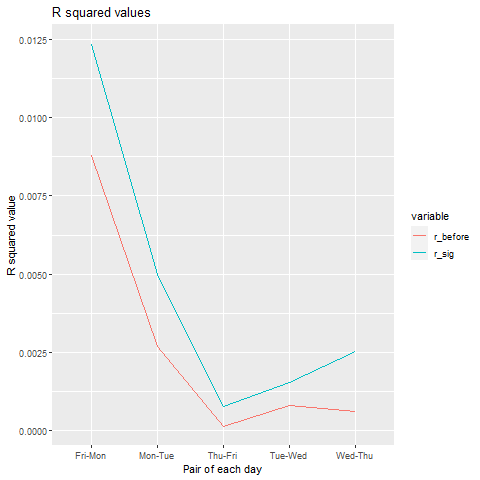

In [69]:
%%R
#We will also visualize the R-squared values and the beta coefficients for the pairs for the model that only includes the significant industries

#First, we need to save the R-squared values and the beta coefficents.
fit_F_M_sig_R2 = summary(fit_F_M_sig)$r.squared
fit_M_Tu_sig_R2 = summary(fit_M_Tu_sig)$r.squared
fit_Tu_W_sig_R2 = summary(fit_Tu_W_sig)$r.squared
fit_W_Th_sig_R2 = summary(fit_W_Th_sig)$r.squared
fit_Th_F_sig_R2 = summary(fit_Th_F_sig)$r.squared
fit_F_M_sig_Beta = fit_F_M_sig$coef[2]
fit_M_Tu_sig_Beta = fit_M_Tu_sig$coef[2]
fit_Tu_W_sig_Beta = fit_Tu_W_sig$coef[2]
fit_W_Th_sig_Beta = fit_W_Th_sig$coef[2]
fit_Th_F_sig_Beta = fit_Th_F_sig$coef[2]

# Let's store these values
r_sig = c(fit_F_M_sig_R2,fit_M_Tu_sig_R2,fit_Tu_W_sig_R2,fit_W_Th_sig_R2,fit_Th_F_sig_R2)
beta_sig = c(fit_F_M_sig_Beta,fit_M_Tu_sig_Beta,fit_Tu_W_sig_Beta,fit_W_Th_sig_Beta,fit_Th_F_sig_Beta)

# We will calculate how much the R-squared values and beta coefficients changed when using all the industries and only the significant industries
r_improve = (r_sig-r_before)/r_before
beta_improve = (beta_sig-beta_before)/beta_before

# Let's plot both R-squared values
names = c("Fri-Mon","Mon-Tue","Tue-Wed","Wed-Thu","Thu-Fri")
r_table =data.frame(names,r_before,r_sig)
r_melt <- melt(r_table, id = "names")
ggplot(data = r_melt) +
  geom_line(aes(x = names, y = value, colour = variable, group = variable))+ labs(x = "Pair of each day",y = "R squared value",title = "R squared values")

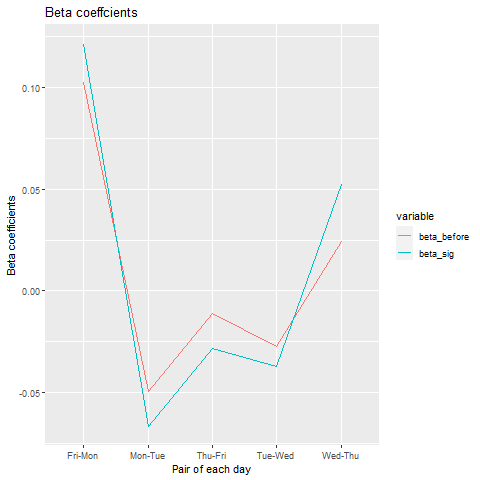

In [70]:
%%R
# Let's plot both beta-coefficeitns
names = c("Fri-Mon","Mon-Tue","Tue-Wed","Wed-Thu","Thu-Fri")
beta_table =data.frame(names,beta_before,beta_sig)
beta_melt <- melt(beta_table, id = "names")
ggplot(data = beta_melt) +
  geom_line(aes(x = names, y = value, colour = variable, group = variable))+ labs(x = "Pair of each day",y = "Beta coefficients",title = "Beta coeffcients")

From the plot above, all the R squared values are small, indicating that only very little of stock price change can be explained by the previous day's stock price change. However, the Friday-Monday linear relationship has a relatively higher R squared value than other pairs, suggesting that Monday's stock price change tends to be more sensitive to Friday's stock price than any other pairs of consecutive two days.

The red line shows the R squared values of linear models done on all industries while the blue line shows the R squared values of linear models done on the industries that has the most significant linear relationships. The list of industries that have the most significant linear relationships is achieved by running linear models by industry and selecting those industries whose p-values are less than 0.05. The two lines has the same pattern: Friday-Monday has the most strongest relationship than any other pairs and the model performance enhanced with selected industries.

This observation from the 2014 to 2017 in the US market to some extent validates the second definition of Monday effect. (Need to rerun the codes on the latest dataset.)